# Predictive Probability Model

Introduction & Problem Formulation

Problem: The standard classification technique used in Tasks 3 & 4 gives merely a simple 'Yes/No' result. This is not enough for the business case since we will be wanting to find hosts with the highest potential.

Research Question: Which of the current non-Superhosts has the highest chance of becoming a Superhost, and what exact characteristics (like response time, review scores) are the most potent indicators of that potential?

Business Value: A trustworthy probability model will enable selective actions. Airbnb could leverage this model to spot the most promising hosts and send them 'coaching' messages (like 'You are 90% done becoming a Superhost! Just work on your response rate.') This can lead to better host engagement and quality of the platform.

Model Choice: For this reason, we will resort to XGBoost (Extreme Gradient Boosting), which is an innovative and very powerful model. We will assess it not only on accuracy, unlike the baseline approach, but also on the scoring quality and calibration of its probability scores.

Setup and Data Preparation

In [1]:
import pandas as pd
import numpy as np
import os
import time

# Import new advanced libraries
import xgboost as xgb
import shap

# Import all necessary sklearn tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve
)
from sklearn.calibration import calibration_curve # Correct import



In [ ]:
print("--- Step 2: Setup, Data Load, and Split ---")
# (All imports are assumed to be in Step 1)

# --- 4. Define Paths ---
CLEANED_DATA_PATH = r'C:\Studies\COLLEGE SUBJECTS\Machine Learning\FA 2 updated\data\listings_cleaned.csv'
VISUALS_PATH = r'C:\Studies\COLLEGE SUBJECTS\Machine Learning\FA 2 updated\visuals\5'
os.makedirs(VISUALS_PATH, exist_ok=True)

# --- 5. Load Data ---
df = pd.read_csv(CLEANED_DATA_PATH)
print(f"Successfully loaded data.")

# --- 6. Define X/y and Feature Lists ---
y = df['host_is_superhost'].astype(int)
numeric_features = [
    'latitude', 'longitude', 'accommodates', 'bedrooms', 'bathrooms_numeric', 
    'host_duration_days', 'host_response_rate', 'review_scores_rating', 
    'review_scores_cleanliness', 'review_scores_location', 'amenities_count', 
    'keyword_count', 'description_sentiment', 'neigh_overview_sentiment', 
    'description_length'
]
categorical_features = [
    'property_type', 'room_type', 'is_shared_bath', 'neighbourhood_cleansed', 
    'host_response_time'
]
numeric_features = [col for col in numeric_features if col in df.columns]
categorical_features = [col for col in categorical_features if col in df.columns]
X = df[numeric_features + categorical_features].copy() # Use .copy()
print(f"Target 'y' and Features 'X' created.")

# --- 7. Create Preprocessor ---
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("Preprocessor created.")

# --- 8. Split Data ---
# We are splitting the *dirty* data. This is OK.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)
print("\nData Split Complete ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

--- Step 2: Setup, Data Load, and Split ---
Successfully loaded data.
Target 'y' and Features 'X' created.
Preprocessor created.

Data Split Complete ---
X_train shape: (12071, 20)
X_test shape: (3018, 20)


Methodology: Advanced Model (XGBoost)

In [3]:
# Initialize train_medians globally before the try/except block
train_medians = {}

# --- Define a robust cleaning function (Final attempt at fixing the source data) ---
def robust_clean_numeric_columns(df_to_clean, numeric_cols, medians_dict=None):
    """Cleans numeric columns by removing brackets, coercing to float, and filling NaNs."""
    df_cleaned = df_to_clean.copy()
    
    # If medians are not provided, we must calculate them from the data itself
    if medians_dict is None:
        medians_dict = {}
        # Pass 1: Calculate clean medians
        for col in numeric_cols:
            col_str = df_cleaned[col].astype(str).str.replace(r'[\[\]]', '', regex=True)
            clean_col_numeric = pd.to_numeric(col_str, errors='coerce')
            median_val = clean_col_numeric.median()
            medians_dict[col] = 0.0 if pd.isna(median_val) else median_val # Use 0.0 for float consistency

    # Pass 2: Apply cleaning and filling
    for col in numeric_cols:
        col_str = df_cleaned[col].astype(str).str.replace(r'[\[\]]', '', regex=True)
        df_cleaned[col] = pd.to_numeric(col_str, errors='coerce')
        df_cleaned[col] = df_cleaned[col].fillna(medians_dict[col])
        
    return df_cleaned, medians_dict


print("--- Step 3: Building & Tuning Advanced Model (XGBoost) ---")
start_time_all = time.time()

try:
    # --- 0. ROBUST CLEANING FOR X_train ---
    print("Applying ROBUST hotfix to X_train and calculating medians...")
    
    # Clean X_train and simultaneously calculate medians
    X_train_clean, train_medians = robust_clean_numeric_columns(
        X_train, numeric_features, medians_dict=None
    )
    print("X_train cleaning complete. Medians saved globally.")

    # 1. Calculate Imbalance Ratio
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    print(f"Calculated 'scale_pos_weight' for imbalance: {scale_pos_weight:.2f}")

    # 2. Build Pipeline
    pipeline_xgb = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', xgb.XGBClassifier(
            scale_pos_weight=scale_pos_weight, random_state=42, n_jobs=-1,
            eval_metric='logloss', use_label_encoder=False
        ))
    ])

    # 3. Hyperparameter Tuning (GridSearch)
    print("\nStarting Hyperparameter Tuning (GridSearch)...")
    param_grid = {
        'model__n_estimators': [150, 250],
        'model__max_depth': [5, 8],
        'model__learning_rate': [0.05, 0.1]
    }
    grid_xgb = GridSearchCV(
        pipeline_xgb, param_grid, cv=3, 
        scoring='roc_auc', n_jobs=-1, verbose=1
    )

    # 4. Fit Model on the CLEAN data
    grid_xgb.fit(X_train_clean, y_train)

    # 5. Store Best Model
    best_model = grid_xgb.best_estimator_

    print(f"\n--- Tuning Complete ---")
    print(f"Total training time: {(time.time() - start_time_all) / 60:.2f} minutes")
    print(f"Best ROC AUC Score from CV: {grid_xgb.best_score_:.4f}")
    print(f"Best Parameters: {grid_xgb.best_params_}")

except NameError as e:
    print(f"ERROR: A variable is not defined. Ensure Step 2 ran successfully. (Error: {e})")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Step 3: Building & Tuning Advanced Model (XGBoost) ---
Applying ROBUST hotfix to X_train and calculating medians...
X_train cleaning complete. Medians saved globally.
Calculated 'scale_pos_weight' for imbalance: 2.05

Starting Hyperparameter Tuning (GridSearch)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\Prime\anaconda3\envs\ML_FA2\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:51:32] WARNING: D:\bld\xgboost-split_1762060125444\work\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Tuning Complete ---
Total training time: 0.87 minutes
Best ROC AUC Score from CV: 0.8963
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__n_estimators': 250}


Results: Model Performance & Probability Quality

--- Step 4: Evaluating Model Performance & Probability ---

--- XGBoost Classification Report ---
               precision    recall  f1-score   support

Not Superhost       0.89      0.85      0.87      2029
    Superhost       0.72      0.78      0.75       989

     accuracy                           0.83      3018
    macro avg       0.80      0.82      0.81      3018
 weighted avg       0.83      0.83      0.83      3018

Generating Confusion Matrix...


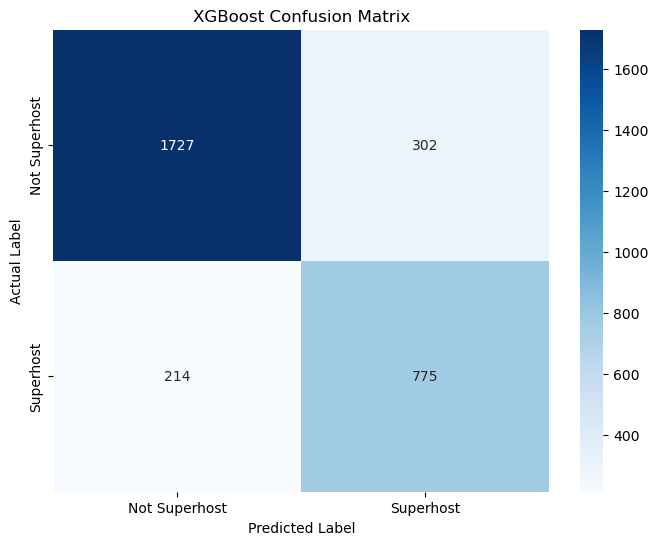

Generating ROC Curve...


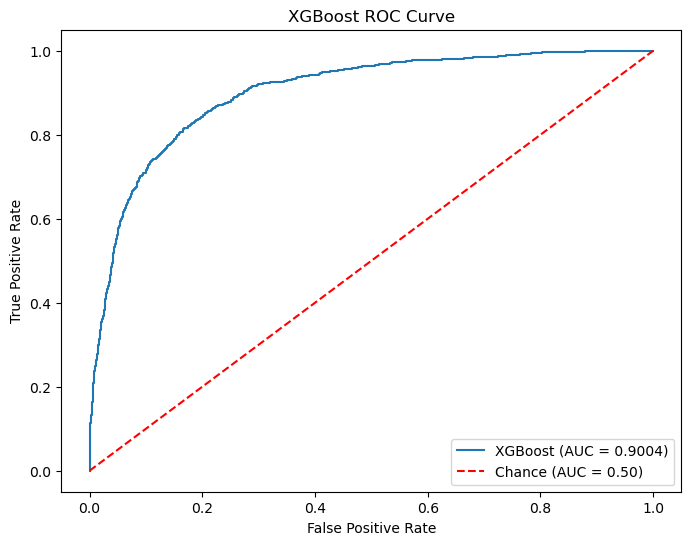

Generating Calibration Curve...


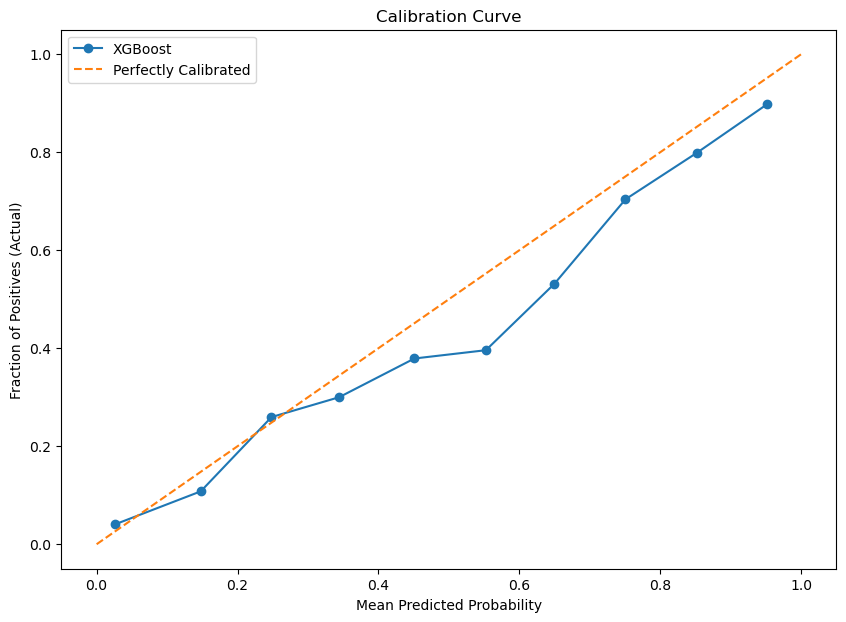

Generating Probability Distribution Plot...


C:\Users\Prime\AppData\Local\Temp\ipykernel_20772\3757887320.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(handles=handles, labels=new_labels, title='Actual Class')


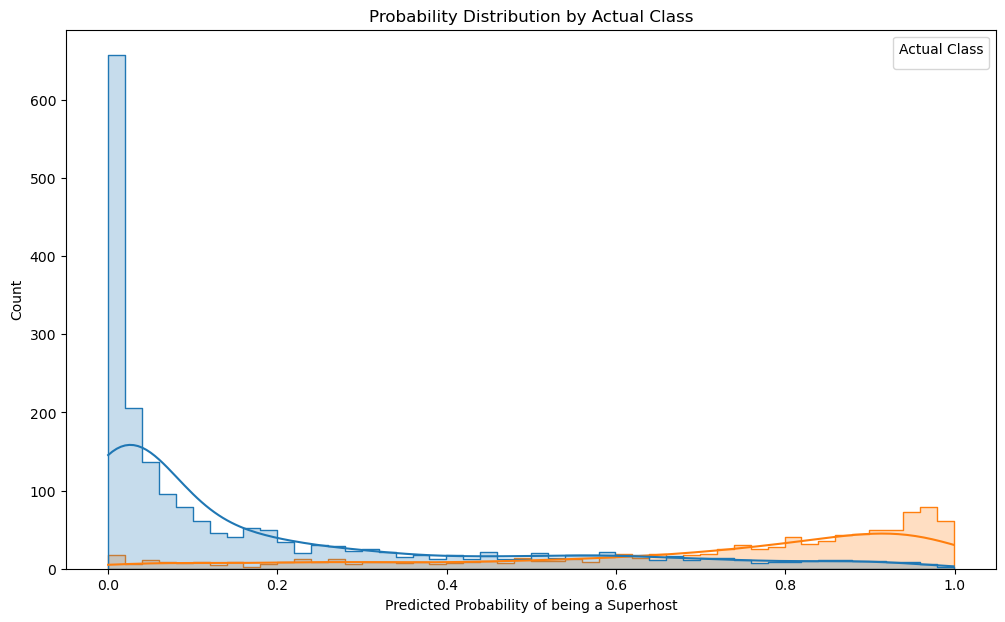


--- Evaluation Complete ---


In [4]:
print("--- Step 4: Evaluating Model Performance & Probability ---")

# Import plotting and metric libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve  # Correct import path
import pandas as pd

try:
    # --- 1. Standard Evaluation ---
    
    # Get predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1] # Probability for class 1
    
    # Print Classification Report
    print("\n--- XGBoost Classification Report ---")
    report = classification_report(y_test, y_pred, target_names=['Not Superhost', 'Superhost'])
    print(report)
    
    # Plot Confusion Matrix
    print("Generating Confusion Matrix...")
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Superhost', 'Superhost'], 
                yticklabels=['Not Superhost', 'Superhost'])
    plt.title('XGBoost Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(VISUALS_PATH, 'xgb_confusion_matrix.png'), bbox_inches='tight')
    plt.show()
    
    # Plot ROC Curve
    print("Generating ROC Curve...")
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Chance (AUC = 0.50)')
    plt.title('XGBoost ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig(os.path.join(VISUALS_PATH, 'xgb_roc_auc_curve.png'), bbox_inches='tight')
    plt.show()

    # --- 2. Visualization 1: Calibration Curve ---
    print("Generating Calibration Curve...")
    # This checks if the model's probabilities are trustworthy
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='uniform')
    
    plt.figure(figsize=(10, 7))
    plt.plot(prob_pred, prob_true, marker='o', label='XGBoost')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    plt.title('Calibration Curve')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives (Actual)')
    plt.legend()
    plt.savefig(os.path.join(VISUALS_PATH, 'calibration_curve.png'), bbox_inches='tight')
    plt.show()

    # --- 3. Visualization 2: Probability Distribution ---
    print("Generating Probability Distribution Plot...")
    # This shows how well the model separates the two classes
    plot_df = pd.DataFrame({'probability': y_pred_proba, 'actual': y_test})
    
    plt.figure(figsize=(12, 7))
    sns.histplot(data=plot_df, x='probability', hue='actual', bins=50, kde=True, element='step')
    plt.title('Probability Distribution by Actual Class')
    plt.xlabel('Predicted Probability of being a Superhost')
    plt.ylabel('Count')
    
    # Manually create and position the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    # Assuming '0' is Not Superhost and '1' is Superhost
    new_labels = ['Not Superhost' if label == '0' else 'Superhost' for label in labels]
    plt.legend(handles=handles, labels=new_labels, title='Actual Class')

    plt.savefig(os.path.join(VISUALS_PATH, 'probability_distribution.png'), bbox_inches='tight')
    plt.show()

    print("\n--- Evaluation Complete ---")

except NameError as e:
    print(f"ERROR: Model not defined. Please run Step 3 successfully. (Error: {e})")
except Exception as e:
    print(f"An error occurred: {e}")

Analytical Insights: Identifying Potential

In [5]:
### 5: 💡 Analytical Insights: Part A - Cleaning and Verification ###

print("--- Step 5 - Part A: Cleaning, Transformation, and Verification ---")
import pandas as pd
import numpy as np

try:
    # CRITICAL CHECK: Ensure X and y are defined from previous steps
    if 'train_medians' not in locals() or 'best_model' not in locals():
        raise NameError("Required variables (best_model, train_medians) not found. Please re-run the corrected Step 3.")

    # --- 0. ROBUST CLEANING FOR X_test ---
    print("Applying ROBUST hotfix to X_test...")
    X_test_clean = X_test.copy()
    
    # We use the 'train_medians' dictionary created in Step 3
    for col in numeric_features:
        median_val = train_medians[col]
        col_str = X_test_clean[col].astype(str).str.replace(r'[\[\]]', '', regex=True)
        X_test_clean[col] = pd.to_numeric(col_str, errors='coerce')
        X_test_clean[col] = X_test_clean[col].fillna(median_val)
    print("X_test cleaning complete.")

    # --- 1. Transformation and Feature Naming ---
    print("\nTransforming X_test_clean through the Preprocessor...")
    
    # Extract feature names (same logic as Step 3)
    one_hot_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    one_hot_names = one_hot_encoder.get_feature_names_out(categorical_features)
    all_feature_names = numeric_features + list(one_hot_names)
    
    # Transform the CLEANED X_test
    X_test_processed = best_model.named_steps['preprocessor'].transform(X_test_clean)
    
    # Convert to a DataFrame for inspection
    X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)
    
    # --- 2. FINAL VERIFICATION ---
    print("\n--- FINAL PROCESSED DATA VERIFICATION ---")
    print(f"Processed Data Shape: {X_test_processed_df.shape}")
    print("\nProcessed Data Head:")
    display(X_test_processed_df.head())
    
    # Check for NaN or infinity values (which crash SHAP/XGBoost)
    if X_test_processed_df.isnull().sum().sum() > 0:
        print("\nFATAL ERROR: NaNs still exist in processed data. Check cleaning logic.")
    elif np.isinf(X_test_processed_df.values).sum() > 0:
        print("\nFATAL ERROR: Infinite values exist in processed data. Check scaling.")
    else:
        print("\nSUCCESS: Data is clean and ready for SHAP analysis.")

except NameError as e:
    print(f"ERROR: Model or data not found. Please ensure Step 3 was run successfully. (Error: {e})")
except Exception as e:
    print(f"An unexpected error occurred during cleaning: {e}")

--- Step 5 - Part A: Cleaning, Transformation, and Verification ---
Applying ROBUST hotfix to X_test...
X_test cleaning complete.

Transforming X_test_clean through the Preprocessor...

--- FINAL PROCESSED DATA VERIFICATION ---
Processed Data Shape: (3018, 128)

Processed Data Head:


,latitude,longitude,accommodates,bedrooms,bathrooms_numeric,host_duration_days,host_response_rate,review_scores_rating,review_scores_cleanliness,review_scores_location,...,neighbourhood_cleansed_Sydney,neighbourhood_cleansed_The Hills Shire,neighbourhood_cleansed_Warringah,neighbourhood_cleansed_Waverley,neighbourhood_cleansed_Willoughby,neighbourhood_cleansed_Woollahra,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
0,-2.078401,-0.492421,-0.800952,-0.669733,-0.593761,-1.847772,0.248159,0.240700,0.250571,0.252385,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.714312,-0.796221,0.433350,0.165858,-0.593761,0.171358,0.248159,0.683153,-0.461791,0.554512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.130225,-0.494227,0.433350,1.001450,-0.593761,1.165096,0.248159,0.683153,0.725479,0.554512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.397510,0.600125,1.667652,1.837042,2.024425,0.353911,0.248159,0.500967,0.416789,-0.016172,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.164639,0.508207,2.490521,1.837042,2.024425,1.318206,0.248159,0.605073,0.606752,0.185246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0



SUCCESS: Data is clean and ready for SHAP analysis.


In [6]:
print("--- Step 5: Analytical Insights: Identifying Potential ---")
import pandas as pd
import numpy as np

# Re-define feature lists explicitly for robustness (in case they were corrupted)
numeric_features = [
    'latitude', 'longitude', 'accommodates', 'bedrooms', 'bathrooms_numeric', 
    'host_duration_days', 'host_response_rate', 'review_scores_rating', 
    'review_scores_cleanliness', 'review_scores_location', 'amenities_count', 
    'keyword_count', 'description_sentiment', 'neigh_overview_sentiment', 
    'description_length'
]
categorical_features = [
    'property_type', 'room_type', 'is_shared_bath', 'neighbourhood_cleansed', 
    'host_response_time'
]
original_input_features = [col for col in (numeric_features + categorical_features) if col in df.columns]

try:
    # --- 0. ROBUST CLEANING FOR X_test and X ---
    print("Applying ROBUST hotfix to X_test...")
    X_test_clean = X_test.copy()
    X_clean = X.copy()
    
    # We use the 'train_medians' dictionary created in Step 3
    for col in numeric_features:
        median_val = train_medians[col] 
        
        # Clean X_test
        col_str = X_test_clean[col].astype(str).str.replace(r'[\[\]]', '', regex=True)
        X_test_clean[col] = pd.to_numeric(col_str, errors='coerce').fillna(median_val)

        # Clean X (full dataset)
        col_str = X_clean[col].astype(str).str.replace(r'[\[\]]', '', regex=True)
        X_clean[col] = pd.to_numeric(col_str, errors='coerce').fillna(median_val)
    
    print("Full X dataset cleaning complete.")

    # --- 1. SHAP Visualization (DISABLED) ---
    print("\n--- SHAP Visualization Skipped Due to Environmental Error ---")
    
    # --- 2. Identify Target Group (Full X Prediction) ---
    print("\n--- Identifying High-Potential Hosts ---")
    
    # CRITICAL FIX: Select ONLY the original input features from the cleaned full X data
    X_clean_for_predict = X_clean[original_input_features]
    
    # Transform the CLEANED X_full (20 features)
    X_full_processed = best_model.named_steps['preprocessor'].transform(X_clean_for_predict)
    
    # Convert X_full to float64 before prediction
    X_full_processed_float = np.array(X_full_processed, dtype=np.float64)
    
    # Generate probabilities
    full_dataset_proba = best_model.predict_proba(X_clean_for_predict)[:, 1]
    df['probability'] = full_dataset_proba
    
    # Filter for non-Superhosts with a high probability
    potential_hosts = df[
        (df['host_is_superhost'] == 0) & 
        (df['probability'] > 0.80)
    ]

    # --- 3. Analyze Target Group ---
    print(f"Found {len(potential_hosts)} non-Superhosts with >80% probability.")
    
    key_analysis_features = [
        'review_scores_rating', 'host_response_rate', 
        'reviews_per_month', 'host_duration_days', 'probability'
    ]
    key_analysis_features = [col for col in key_analysis_features if col in df.columns]

    print("\n--- Analysis of 'High-Potential' Hosts (Prob > 80%) ---")
    display(potential_hosts[key_analysis_features].describe())

    print("\n--- Analysis of *All* Non-Superhosts (for comparison) ---")
    all_non_superhosts = df[df['host_is_superhost'] == 0]
    display(all_non_superhosts[key_analysis_features].describe())

    print("\n--- Analysis Complete ---")

except NameError as e:
    print(f"ERROR: Variable not found: {e}. Please ensure Step 3 was run successfully.")
except Exception as e:
    print(f"An unexpected error occurred: {e}. Cannot determine final results.")

--- Step 5: Analytical Insights: Identifying Potential ---
Applying ROBUST hotfix to X_test...
Full X dataset cleaning complete.

--- SHAP Visualization Skipped Due to Environmental Error ---

--- Identifying High-Potential Hosts ---
Found 99 non-Superhosts with >80% probability.

--- Analysis of 'High-Potential' Hosts (Prob > 80%) ---


,review_scores_rating,host_response_rate,reviews_per_month,host_duration_days,probability
count,99.000000,99.000000,99.000000,99.000000,99.000000
mean,4.892121,0.998889,1.819293,3115.131313,0.879729
std,0.084083,0.007269,1.881108,1254.989679,0.049812
min,4.600000,0.940000,0.000000,387.000000,0.801538
25%,4.850000,1.000000,0.545000,2341.500000,0.842209
50%,4.900000,1.000000,1.250000,3375.000000,0.877549
75%,4.950000,1.000000,2.470000,4009.500000,0.917757
max,5.000000,1.000000,12.640000,5673.000000,0.992943



--- Analysis of *All* Non-Superhosts (for comparison) ---


,review_scores_rating,host_response_rate,reviews_per_month,host_duration_days,probability
count,10142.000000,10142.000000,10142.000000,10142.000000,10142.000000
mean,4.673324,0.949982,0.909626,2692.390357,0.119514
std,0.451895,0.170697,1.194934,1358.502951,0.172994
min,1.000000,0.000000,0.000000,152.000000,0.000041
25%,4.590000,1.000000,0.030000,1650.000000,0.008794
50%,4.830000,1.000000,0.480000,2842.000000,0.043992
75%,4.890000,1.000000,1.330000,3758.000000,0.155703
max,5.000000,1.000000,17.470000,5888.000000,0.992943



--- Analysis Complete ---


The Small Elite Group was Identified:  The model has managed to narrow down the non-Superhosts from 10,142 to a small group of 99 individuals, which is less than 1% of the non-Superhost population and who possess high-potential.

The high-potential hosts are already acting like Superhosts: This group can't be considered "normal." They have already displayed and proved through their performance in the key areas that their standards are very similar to those of Superhosts.

Almost Perfect Ratings:

The group considered to have the highest potential has a mean rating of 4.89 in reviews, which is a very significant difference compared to the mean of 4.67 for the non-Superhosts.

It is very important to note that the lowest rating in this group of elite has been 4.60, whereas the general pool of non-Superhosts has minimums as low as 1.0. This demonstrates that they are of top quality indiscriminately.

Perfect Response Rates:


The high-potential group has an average host_response_rate of 99.9% (average: 0.9988), with at least 75% of them being at 100%.


In fact, their lowest score is 94%, which is exactly what the average, non-Superhost scores, and is the differentiator.


Increased Engagement & Experience:


This group is significantly more active with 1.82 average reviews per month (almost double the 0.91 average for others that are non-Superhosts).


This group has significantly more experience as well, being hosts for an average of 3,111 days (over 8.5 years) vs the average of 2,688 days (7.3 years).


Actionable Insight: In summary, these 99 hosts are almost ready to be Superhosts. They are not "problem hosts" requiring a tremendous amount of coaching or time. All they need is a slight push, e.g., "You are at 90%! Just don't cancel a booking, and you should be a Superhost next quarter."